<a href="https://colab.research.google.com/github/Sayandeep27/Natural-Language-Processing/blob/main/Sentiment_Analysis_Using_Transformer_and_LSTM_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
from tensorflow.keras.datasets import imdb

# Load data
num_words = 20000
max_len = 200
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Pad sequences
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

print(f'Training data shape: {x_train.shape}')
print(f'Testing data shape: {x_test.shape}')


17464789/17464789 [==============================] - 0s 0us/step
Training data shape: (25000, 200)
Testing data shape: (25000, 200)


In [3]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [4]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [5]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

transformer_model = Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [6]:
lstm_inputs = Input(shape=(max_len,))
x = Embedding(num_words, embed_dim)(lstm_inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
lstm_outputs = Dense(1, activation="sigmoid")(x)

lstm_model = Model(inputs=lstm_inputs, outputs=lstm_outputs)
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [7]:
# Train Transformer model
transformer_history = transformer_model.fit(
    x_train, y_train, epochs=5, batch_size=32, validation_split=0.2
)

# Train LSTM model
lstm_history = lstm_model.fit(
    x_train, y_train, epochs=5, batch_size=32, validation_split=0.2
)

# Evaluate models
transformer_loss, transformer_accuracy = transformer_model.evaluate(x_test, y_test)
lstm_loss, lstm_accuracy = lstm_model.evaluate(x_test, y_test)

print(f"Transformer Accuracy: {transformer_accuracy:.4f}")
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")


Epoch 1/5
625/625 [==============================] - 83s 129ms/step - loss: 0.5620 - accuracy: 0.6847 - val_loss: 0.3789 - val_accuracy: 0.8348
Epoch 2/5
625/625 [==============================] - 77s 123ms/step - loss: 0.2666 - accuracy: 0.8960 - val_loss: 0.2938 - val_accuracy: 0.8804
Epoch 3/5
625/625 [==============================] - 69s 111ms/step - loss: 0.1411 - accuracy: 0.9543 - val_loss: 0.4344 - val_accuracy: 0.8550
Epoch 4/5
625/625 [==============================] - 71s 114ms/step - loss: 0.0836 - accuracy: 0.9743 - val_loss: 0.4762 - val_accuracy: 0.8570
Epoch 5/5
625/625 [==============================] - 70s 112ms/step - loss: 0.0545 - accuracy: 0.9847 - val_loss: 0.5294 - val_accuracy: 0.8608
Epoch 1/5
625/625 [==============================] - 118s 182ms/step - loss: 0.4689 - accuracy: 0.7613 - val_loss: 0.3040 - val_accuracy: 0.8722
Epoch 2/5
625/625 [==============================] - 112s 179ms/step - loss: 0.2215 - accuracy: 0.9175 - val_loss: 0.3151 - val_accurac

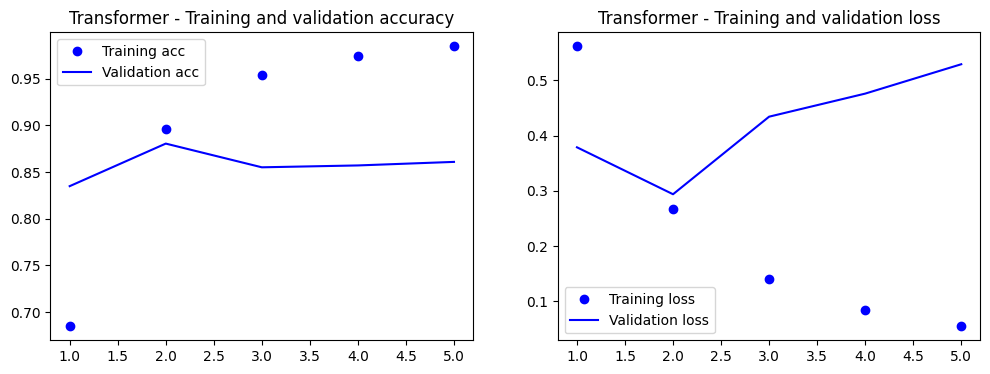

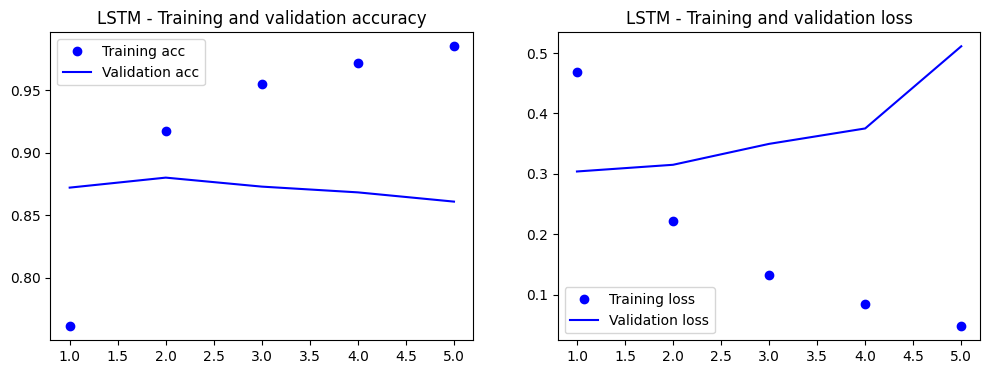

In [8]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()

    plt.show()

plot_history(transformer_history, "Transformer")
plot_history(lstm_history, "LSTM")
